#Question Answering (QA) on [CoQA](https://stanfordnlp.github.io/coqa/) dataset: a conversational QA dataset.

Authors:
* Nicola Carrassi, ID: 0001037813 nicola.carrassi@studio.unibo.it
* Gabriele Colasuonno, ID: 0001037489 gabriele.colasuonno@studio.unibo.it
* Antonio Guerra, ID: 0001037365 antonio.guerra7@studio.unibo.it

# Assignment 2

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Keywords**: Transformers, Question Answering, CoQA

## Deadlines

* **December 11**, 2022: deadline for having assignments graded by January 11, 2023
* **January 11**, 2023: deadline for half-point speed bonus per assignment
* **After January 11**, 2023: assignments are still accepted, but there will be no speed bonus

## Overview

### Problem

Question Answering (QA) on [CoQA](https://stanfordnlp.github.io/coqa/) dataset: a conversational QA dataset.

### Task

Given a question $Q$, a text passage $P$, the task is to generate the answer $A$.<br>
$\rightarrow A$ can be: (i) a free-form text or (ii) unanswerable;

**Note**: an question $Q$ can refer to previous dialogue turns. <br>
$\rightarrow$ dialogue history $H$ may be a valuable input to provide the correct answer $A$.

### Models

We are going to experiment with transformer-based models to define the following models:

1.  $A = f_\theta(Q, P)$

2. $A = f_\theta(Q, P, H)$

where $f_\theta$ is the transformer-based model we have to define with $\theta$ parameters.

## The CoQA dataset

<center>
    <img src="https://drive.google.com/uc?export=view&id=16vrgyfoV42Z2AQX0QY7LHTfrgektEKKh" width="750"/>
</center>

For detailed information about the dataset, feel free to check the original [paper](https://arxiv.org/pdf/1808.07042.pdf).



## Rationales

Each QA pair is paired with a rationale $R$: it is a text span extracted from the given text passage $P$. <br>
$\rightarrow$ $R$ is not a requested output, but it can be used as an additional information at training time!

## Dataset Statistics

* **127k** QA pairs.
* **8k** conversations.
* **7** diverse domains: Children's Stories, Literature, Mid/High School Exams, News, Wikipedia, Reddit, Science.
* Average conversation length: **15 turns** (i.e., QA pairs).
* Almost **half** of CoQA questions refer back to **conversational history**.
* Only **train** and **validation** sets are available.

## Dataset snippet

The dataset is stored in JSON format. Each dialogue is represented as follows:

```
{
    "source": "mctest",
    "id": "3dr23u6we5exclen4th8uq9rb42tel",
    "filename": "mc160.test.41",
    "story": "Once upon a time, in a barn near a farm house, there lived a little white kitten named Cotton. 
    Cotton lived high up in a nice warm place above the barn where all of the farmer's horses slept. [...]" % <-- $P$
    "questions": [
        {
            "input_text": "What color was Cotton?",   % <-- $Q_1$
            "turn_id": 1
        },
        {
            "input_text": "Where did she live?",
            "turn_id": 2
        },
        [...]
    ],
    "answers": [
        {
            "span_start": 59,   % <-- $R_1$ start index
            "spand_end": 93,    % <-- $R_1$ end index
            "span_text": "a little white kitten named Cotton",   % <-- $R_1$
            "input_text" "white",   % <-- $A_1$      
            "turn_id": 1
        },
        [...]
    ]
}
```

### Simplifications

Each dialogue also contains an additional field ```additional_answers```. For simplicity, we **ignore** this field and only consider one groundtruth answer $A$ and text rationale $R$.

CoQA only contains 1.3% of unanswerable questions. For simplicity, we **ignore** those QA pairs.

## [Task 1] Remove unaswerable QA pairs

Write your own script to remove unaswerable QA pairs from both train and validation sets.

####Libraries Import
We are also setting up Google Drive in order to save our progress (It will be used later)

In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate

In [ ]:
from google.colab import drive
from google.colab import files

MODEL_LOCAL_PATH = '/content/gdrive/MyDrive/unibo/NLP/'

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


#### Dataset Download


In [ ]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [ ]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

coqa-train-v1.0.json: 49.0MB [00:04, 9.97MB/s]                            


Download completed!


coqa-dev-v1.0.json: 9.09MB [00:03, 2.46MB/s]                            

Download completed!


####Dataset encoding
After we have downloaded the .json files of the CoQA dataset we encode them using Pandas Dataframe.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def encode_dataset(path : str) -> pd.DataFrame:
  """
  The function allows to encode the CoQA dataset from .json format to a Pandas Dataframe

  :param path: path of the .json file to encode

  :return pd.DataFrame(): the encoded Pandas Dataframe 
  """

  coqa = pd.read_json(path)
  coqa.head()

  del coqa['version']
  coqa.head()

  cols = ["doc_id", "source", "context","turn_id", "question", "answer","rational"]

  df_row = []

  for index, row in coqa.iterrows():
    
    for i in range(len(row["data"]["questions"])):
        temp_list = []
        temp_list.append(index+1)
        temp_list.append(row["data"]["source"])

        #remove empty lines and white spaces
        temp_list.append(row["data"]["story"].replace('\n', '').strip())
        temp_list.append(row["data"]["questions"][i]["turn_id"])
        temp_list.append(row["data"]["questions"][i]["input_text"])
        temp_list.append(row["data"]["answers"][i]["input_text"])
        temp_list.append(row["data"]["answers"][i]["span_text"])
        
        df_row.append(temp_list)

  return pd.DataFrame(df_row, columns=cols) 


In [ ]:
DATASET_FOLDER = 'coqa/'

df_train = encode_dataset(DATASET_FOLDER+'train.json')
df_test = encode_dataset(DATASET_FOLDER+'test.json')

print('Len of training set: ', len(df_train))
print('Len of test set: ', len(df_test))
df_train.head()

Len of training set:  108647
Len of test set:  7983


,doc_id,source,context,turn_id,question,answer,rational
0,1,wikipedia,"The Vatican Apostolic Library (), more commonl...",1,When was the Vat formally opened?,It was formally established in 1475,Formally established in 1475
1,1,wikipedia,"The Vatican Apostolic Library (), more commonl...",2,what is the library for?,research,he Vatican Library is a research library
2,1,wikipedia,"The Vatican Apostolic Library (), more commonl...",3,for what subjects?,"history, and law",Vatican Library is a research library for hist...
3,1,wikipedia,"The Vatican Apostolic Library (), more commonl...",4,and?,"philosophy, science and theology",Vatican Library is a research library for hist...
4,1,wikipedia,"The Vatican Apostolic Library (), more commonl...",5,what was started in 2014?,a project,"March 2014, the Vatican Library began an initi..."


####Drop Unanswerable Rows
After the encoding of our datasets we can finally complete the task 1: dropping out all the unanswerable QA pairs.

In [ ]:
training_unknown_answer_rows = df_train.loc[df_train['answer'] == 'unknown'].index
test_unknown_answer_rows = df_test.loc[df_test['answer'] == 'unknown'].index

print('Num of unanswerable questions in the training set: ', len(training_unknown_answer_rows) )
print('Num of unanswerable questions in the test set: ', len(test_unknown_answer_rows) )

df_train.drop(training_unknown_answer_rows, inplace = True)
df_test.drop(test_unknown_answer_rows, inplace = True)

print('Len of training set: ', len(df_train))
print('Len of test set: ', len(df_test))

Num of unanswerable questions in the training set:  1371
Num of unanswerable questions in the test set:  66
Len of training set:  107276
Len of test set:  7917


####Data Inspection
We spend some time in checking accurately the dataset format and how to retrieve the tasks' inputs and outputs, in this subsection we will explore things like the datasets' sources distribution and some entries length.

Since the assignment requires the use of QA history (Almost half of CoQA questions refer back to conversational history) we will define a function that computes it and then extend our dataframe to add this information.

In [ ]:
def extend_with_history(df : pd.DataFrame) -> pd.DataFrame:  
  '''
  This function allows to compute the entire QA history for each document 
  in the dataframe. Then append to each row only the history part that comes 
  before each question.

  :param df: the pandas dataframe for which we want to compute the QA history

  :return extended_df: the pandas dataframe that has been extended with the history
  '''
  documents_id = df['doc_id'].unique()
  history = []

  for doc_id in documents_id:
    tmp = df.loc[ (df['doc_id'] == doc_id) ]
    history.append(tmp[['question','answer']].to_numpy())   

  
  expanded_history = []
  for h in history:
      for i in range(len(h)):
        expanded_history.append(h[:i])

  extended_df = df.copy()
  extended_df['history'] = expanded_history
  
  return extended_df

In [ ]:
df_train = extend_with_history(df_train)
df_test  = extend_with_history(df_test)

df_test.head()

,doc_id,source,context,turn_id,question,answer,rational,history
0,1,mctest,"Once upon a time, in a barn near a farm house,...",1,What color was Cotton?,white,a little white kitten named Cotton,[]
1,1,mctest,"Once upon a time, in a barn near a farm house,...",2,Where did she live?,in a barn,"in a barn near a farm house, there lived a lit...","[[What color was Cotton?, white]]"
2,1,mctest,"Once upon a time, in a barn near a farm house,...",3,Did she live alone?,no,Cotton wasn't alone,"[[What color was Cotton?, white], [Where did s..."
3,1,mctest,"Once upon a time, in a barn near a farm house,...",4,Who did she live with?,with her mommy and 5 sisters,with her mommy and 5 other sisters,"[[What color was Cotton?, white], [Where did s..."
4,1,mctest,"Once upon a time, in a barn near a farm house,...",5,What color were her sisters?,orange and white,her sisters were all orange with beautiful whi...,"[[What color was Cotton?, white], [Where did s..."


Now we will begin the inspection of our data, first of all we will plot the sources distribution in a pie chart.

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = df_train['source'].unique()

train_counts = []
test_counts =[]

train_source_values = df_train['source'].value_counts()
test_source_values = df_test['source'].value_counts()

for label in labels:
  train_counts.append(train_source_values[label])
  test_counts.append(test_source_values[label])

fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['Train set', 'Test set'])

fig.add_trace(go.Pie(labels=labels, values=train_counts, name="Train set"), 1, 1)
fig.add_trace(go.Pie(labels=labels, values=test_counts, name="Test set"), 1, 2)

fig.update_traces(hoverinfo="label+percent+name")

fig.update_layout(title_text="Source distribution", width=800, height=400)
fig.show()

The only thing that we can see is that in both train set and test set the sources are evenly distributed, the only exception is for "mctest" that in the train set is less present.

Another interesting data is the discussion length: the number of QA pairs in each conversation, we will plot a bar graph for the train set and one for the test set.

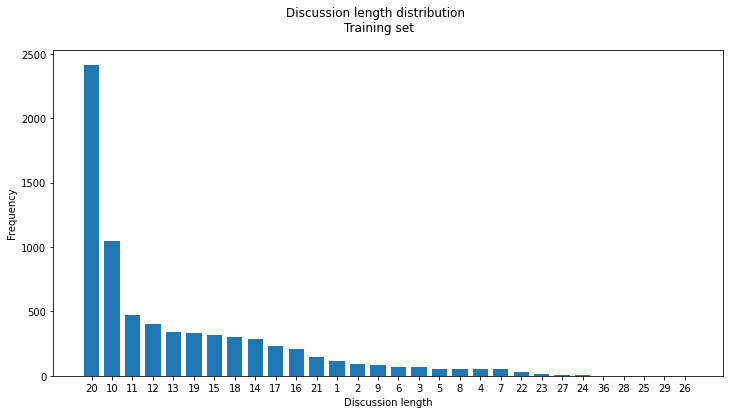

In [ ]:
query_train = df_train.groupby('doc_id')['turn_id'].max().value_counts()
train_labels = [str(s) for s in query_train.keys().to_list()]
train_values = query_train.to_list()

fig = plt.figure(figsize = (12,6))
fig.suptitle('Discussion length distribution \n Training set')
bars = plt.bar(train_labels, train_values, width = 0.75)
plt.xlabel('Discussion length')
plt.ylabel('Frequency')
plt.show()

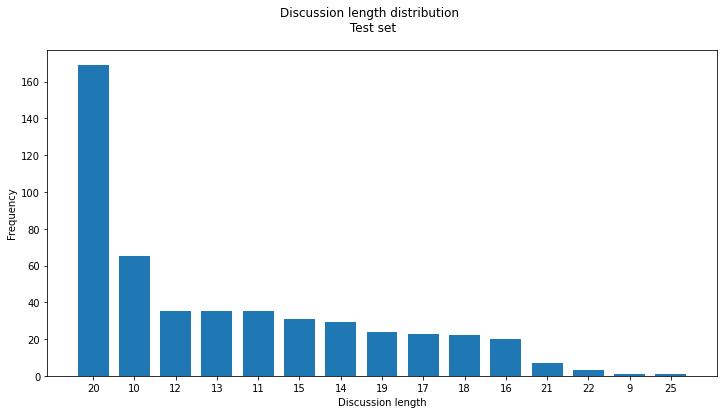

In [ ]:
query_test = df_test.groupby('doc_id')['turn_id'].max().value_counts()
test_labels = [str(s) for s in query_test.keys().to_list()]
test_values = query_test.to_list()

fig = plt.figure(figsize = (12,6))
fig.suptitle('Discussion length distribution \n Test set')
plt.bar(test_labels, test_values, width = 0.75)
plt.xlabel('Discussion length')
plt.ylabel('Frequency')
plt.show()

As we can see in both sets the most frequent discussion length is 20.

Another information is the number of words composing the contexts and the answers: these will be useful during the configuration of our models since we will have a limited input and output size. 

In [ ]:
def get_column_stats(df : pd.DataFrame, column : str):
  '''
  This function allows to compute the minimum,maximum and average number
  of words in a datframe's column

  :param df: the dataframe that will be inspected
  :param column: the name of the column considered

  :return:
    - number_of_words: list containing all the entries number of words
    - max: the maximum number of word
    - min: the minimum number of word
    - avg: the average number of word
  '''
  number_of_words = []

  for line in df[column].to_numpy():
    number_of_words.append(len(line.split()))
  
  number_of_words = np.array(number_of_words)
  min = round(np.min(number_of_words))
  max = round(np.max(number_of_words))
  avg = round(np.mean(number_of_words))
  return number_of_words, min, max, avg

In [ ]:
context_num_words, context_min, context_max, context_avg = get_column_stats(df_train, 'context')
answer_num_words, answer_min, answer_max, answer_avg = get_column_stats(df_train, 'answer')

print(f'***************CONTEXT*****************')
print(f'Min number of words: {context_min}')
print(f'Max number of words: {context_max}')
print(f'Average number of words: {context_avg}')

print(f'\n***************Answer*****************')
print(f'Min number of words: {answer_min}')
print(f'Max number of words: {answer_max}')
print(f'Average number of words: {answer_avg}')

***************CONTEXT*****************
Min number of words: 70
Max number of words: 1030
Average number of words: 271

***************Answer*****************
Min number of words: 1
Max number of words: 353
Average number of words: 3


As we can see we get a very odd result for the answer length: the max number of words is 353 despite the average length is just 3. We decided to further investigate printing all the answers which length is bigger then 45.

In [ ]:
outline_indexes = np.where(np.array(answer_num_words)>45)[0]

for idx in outline_indexes:
  print('context:', df_train['context'].iloc[idx])
  print('question:', df_train['question'].iloc[idx])
  print('rational:', df_train['rational'].iloc[idx])
  print('answer:', df_train['answer'].iloc[idx])
  print('********************************************************\n')

context: A Chinese actor's divorce from his wife, over her alleged extramarital affair, has social media buzzing, with posts about the subject gaining over five billion views. Wang Baoqiang announced online on Sunday that he was divorcing his wife, Ma Rong, and sacking his agent, Song Zhe. He alleged that his marriage broke down after his wife had an affair with his agent, and that she had also transferred the couple's joint assets. Ma has hit back at Wang, accusing him of abandoning their family. The topic has sparked a debate about relationships and divorce. It seems Wang's situation has struck a chord with many - which could explain the number of views, which are high even by Chinese standards. The divorce quickly became a top trending topic in China. According to micro blog Sina Weibo, posts with the hashtag "Wang BaoQiang Divorce" have been viewed over five billion times. Chinese netizens seem to have rallied around Wang, with topics like "Wang Don't Cry" "Wang We Support You", qu

As we can see the answers are incorrect since they are a copy of the rational, we have checked to .json file too and decided to drop these rows.

In [ ]:
df_train.drop(df_train.iloc[outline_indexes].index, inplace = True)

Now we can check again the stats on the training set.

In [ ]:
context_num_words, context_min, context_max, context_avg = get_column_stats(df_train, 'context')
answer_num_words, answer_min, answer_max, answer_avg = get_column_stats(df_train, 'answer')

print(f'***************CONTEXT*****************')
print(f'Min number of words: {context_min}')
print(f'Max number of words: {context_max}')
print(f'Average number of words: {context_avg}')


print(f'\n***************Answer*****************')
print(f'Min number of words: {answer_min}')
print(f'Max number of words: {answer_max}')
print(f'Average number of words: {answer_avg}')

***************CONTEXT*****************
Min number of words: 70
Max number of words: 1030
Average number of words: 271

***************Answer*****************
Min number of words: 1
Max number of words: 45
Average number of words: 3


Both the models we will use have an input max length of 512 words. We will now check the number of context that are greater than it.

In [ ]:
model_max_length = 512

exceeding_context = context_num_words[ np.array(context_num_words) > model_max_length]
print(f'There are {len(exceeding_context) } exceeding context, around {round((len(exceeding_context) * 100) / len(context_num_words),2)}% of the total.')

There are 1091 exceeding context, around 1.02% of the total.


As we can see a very low percentage of context will exceed the max length, so we can proceed with the next tasks.

## [Task 2] Train, Validation and Test splits

CoQA only provides a train and validation set since the test set is hidden for evaluation purposes.

We'll consider the provided validation set as a test set. <br>
$\rightarrow$ Write your own script to:
* Split the train data in train and validation splits (80% train and 20% val)
* Perform splits such that a dialogue appears in one split only! (i.e., split at dialogue level)
* Perform splitting using the following seed for reproducibility: 42

#### Reproducibility Memo

Check back tutorial 2 on how to fix a specific random seed for reproducibility!

### Reproducibility
Reproducibility is essential for correct evaluation. So, we are setting 42 as the random seed for all sources of randomness.

In [ ]:
import random
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
RANDOM_SEED = 42

def set_reproducibility(seed: int):
    """
    Set the same random seed to different sources of randomness

    :param seed: random seed
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_reproducibility(RANDOM_SEED)

### Split the dataset
Once we have encoded our datasets and setting up the random seed, we can finally split the training set into training and validation sets. The dataset will be divided as follows:
- The training set will contain the 80% of dialogue from the original training set;
- The validation set will contain 20% of the remaining dialogues from the original training set;
- The original validation set will be considered as the test set.
<br>
Moreover, it is important to note that splits are done at the dialogue level, so the same dialogue can not appear in two different sets.

In [ ]:
def split_dataset_dialogue_level(df : pd.DataFrame, train_set_ratio : float = 0.8, shuffle : bool = True):
  """
  Splits a dataframe at dialogue level into training and validation set.

  :param df: Pandas DataFrame to be splitted
  :train_set_ratio: Ratio of the dialogue in the training set
  :shuffle: allows to shuffle the dataset before splitting

  :return:
    - new_df_train: Pandas DataFrame containing all the documents of the training set
    - df_val : Pandas DataFrame containing all the documents of the test set
  """
  dialogues = df['doc_id'].unique()

  if shuffle:
    np.random.shuffle(dialogues)
  
  sep = int(train_set_ratio*len(dialogues))

  train_dialogues = dialogues[:sep]
  val_dialogues = dialogues[sep:]

  new_df_train = df.loc[df['doc_id'].isin(train_dialogues)]
  df_val = df.loc[df['doc_id'].isin(val_dialogues)]

  return new_df_train, df_val

In [ ]:
df_train, df_val = split_dataset_dialogue_level(df_train)

print('Dataset splits statistics: ')
print(f'Train data shape: {df_train.shape}')
print(f'Validation data shape: {df_val.shape}')
print(f'Test data shape: {df_test.shape}')

Dataset splits statistics: 
Train data shape: (85712, 8)
Validation data shape: (21550, 8)
Test data shape: (7917, 8)


## [Task 3] Model definition

Write your own script to define the following transformer-based models from [huggingface](https://HuggingFace.co/).

* [M1] DistilRoBERTa (distilberta-base)
* [M2] BERTTiny (bert-tiny)

**Note**: Remember to install the ```transformers``` python package!

**Note**: We consider small transformer models for computational reasons!

### Load the models and tokenizers
In this task we will load and configure the tokenizers for both models.
To handle the QA History we tried several approaches:
- Firstly, we tried to append it as plain text both before the question or after the context and we have observed that in the latter we get better results;
- Then, we tried to improve it using the SEP special tokens provided by the tokenizers to split the context and begin of history and each pair of question and answer without achieving much improvements;
- Finally, we have added three special tokens to our tokenizers in order to separate the QA History start and each pair of questions and answers and with this approach we get the best results.
<br>

Next, regarding the model paramaters we chose them based on the statistics that we have computed in Task 1:
- we chose to set the max length of the encoder input to 512 tokens, so that only around 1% of dialogue will be truncated;
- we set the max length to the decoder output to 32 tokens, since the average number of tokens in the answers is 3.

In [ ]:
from transformers import EncoderDecoderModel,AutoTokenizer

HISTORY_QUESTION_TOKEN = '[HEQ]' #tag representing the start of a question in the history
HISTORY_ANSWER_TOKEN = '[HEA]' #tag representing the start of an answer in the history
HISTORY_START_TOKEN = '[HES]' #tag representing the start of the questions-answers history

special_token_dict = {'additional_special_tokens' : [HISTORY_START_TOKEN,HISTORY_QUESTION_TOKEN, HISTORY_ANSWER_TOKEN] }

#Constants representing the models name
BERT_TINY = 'prajjwal1/bert-tiny'
DISTILROBERTA = 'distilroberta-base'

#Constans representing the max input tokens accepted by the encoder and the max output tokens of the decoder
ENCODER_MAX_LENGTH = 512
DECODER_MAX_LENGTH = 32

#Loading the tokenizers for the two models
bert_tiny_tokenizer = AutoTokenizer.from_pretrained(BERT_TINY)
distilroberta_tokenizer = AutoTokenizer.from_pretrained(DISTILROBERTA)

bert_tiny_tokenizer.add_special_tokens(special_token_dict)
distilroberta_tokenizer.add_special_tokens(special_token_dict)

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

3

Next we will define the function that will be used to load and configure the models.
We chose not to use the "*tie_encoder_decoder*" option of *EncoderDecoderModel.from_encoder_decoder_pretrained()* as it worsens the results and does not speed up the training too much.

In [ ]:
def create_model(petrained_model_name : str, tokenizer ):
  """
  Loads and configure a encoder-decoder pre-trained model via HuggingFace transformers library.

  :param petrained_model_name: name of the model to load
  :param tokenizer: the tokenizer of the model to be loaded

  :return:
    - model: pretrained encoder-decoder transformer model

  """
  #model = EncoderDecoderModel.from_encoder_decoder_pretrained(petrained_model_name, petrained_model_name, tie_encoder_decoder=True).to(device) 
  model = EncoderDecoderModel.from_encoder_decoder_pretrained(petrained_model_name, petrained_model_name).to(device) 

  model.config.early_stopping = True
  model.config.decoder_start_token_id = tokenizer.cls_token_id
  model.config.eos_token_id = tokenizer.sep_token_id
  model.config.pad_token_id = tokenizer.pad_token_id
  model.config.max_new_tokens = DECODER_MAX_LENGTH
  
  model.encoder.resize_token_embeddings(len(tokenizer))
  model.decoder.resize_token_embeddings(len(tokenizer))

  return model

## [Task 4] Question generation with text passage $P$ and question $Q$

We want to define $f_\theta(P, Q)$. 

Write your own script to implement $f_\theta$ for each model: M1 and M2.

#### Formulation

Consider a dialogue on text passage $P$. 

For each question $Q_i$ at dialogue turn $i$, your model should take $P$ and $Q_i$ and generate $A_i$.

### Definition of $f_\theta(P, Q)$

We defined a function that generates the correct answer for a given context and question.

In [ ]:
def generate_answer(model, tokenizer, context : str, question : str):
  """
  This function generates an answer for a given question in a given context.
  To do this, first the input is tokenized using the tokenizer,
  then the model is used to generate the answer ID tokens,
  and finally the tokenizer is used to decode the answer.

  :param model: the model used to generate the answer
  :param tokenizer: the tokenizer of the model
  :param context: string representing the context of the question
  :param question: string representing the question

  :return:
    - the generated answer as a string

  """
  inputs = tokenizer(question,
                     context,
                     padding="max_length",
                     truncation="only_second",
                     max_length=ENCODER_MAX_LENGTH)

  greedy_output = model.generate(torch.as_tensor([inputs.input_ids]).to(device),
                                 attention_mask = torch.as_tensor([inputs.attention_mask]).to(device),
                                 max_new_tokens = DECODER_MAX_LENGTH
                                 )
  
  return tokenizer.decode(greedy_output.tolist()[0],skip_special_tokens=True )


## [Task 5] Question generation with text passage $P$, question $Q$ and dialogue history $H$

We want to define $f_\theta(P, Q, H)$. Write your own script to implement $f_\theta$ for each model: M1 and M2.

#### Formulation

Consider a dialogue on text passage $P$. 

For each question $Q_i$ at dialogue turn $i$, your model should take $P$, $Q_i$, and $H = \{ Q_0, A_0, \dots, Q_{i-1}, A_{i-1} \}$ to generate $A_i$.

### Definition of $f_\theta(P, Q, H)$

We defined a function that generates an answer for a given context and question taking into account the past questions-answers history.
To use the history we have first flatten the list containing the list of question-answer pair using the special tokens defined in the Task 2, then we have concatenate the flatted history to the context and used this as input for our tokenizer and model.

In [ ]:
def generate_answer_with_history(model, tokenizer, context: str, question: str, history):
  """
  This function generates an answer for a given question in a given context
  taking into account the questions-answer history.
  To do this, first the history is flatten into a string using three special tokens,
  then both the context and the flat history are tokenized,
  after the model is used to generate the answer ID tokens,
  and finally the tokenizer is used to decode the answer.

  :param model: the model used to generate the answer
  :param tokenizer: the tokenizer of the model
  :param context: string representing the context of the question
  :param question: string representing the question
  :param history: List of string list represening past questions and answers on the same context

  :return:
    - the generated answer as a string

  """

  flat_history = HISTORY_START_TOKEN
  for q, a in history:
    flat_history += ' ' + HISTORY_QUESTION_TOKEN + ' ' + q + ' ' + HISTORY_ANSWER_TOKEN + ' ' + a

  inputs = tokenizer(question,
                     context + ' ' + flat_history,
                     padding="max_length",
                     truncation="only_second",
                     max_length=ENCODER_MAX_LENGTH)

  greedy_output = model.generate(torch.as_tensor([inputs.input_ids]).to(device),
                                 attention_mask = torch.as_tensor([inputs.attention_mask]).to(device),
                                 max_new_tokens = DECODER_MAX_LENGTH
                                 )
  
  return tokenizer.decode(greedy_output.tolist()[0],skip_special_tokens=True )

## [Task 6] Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

Write your own script to train and evaluate your $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$ models.

### Instructions

* Perform multiple train/evaluation seed runs: [42, 2022, 1337].$^1$
* Evaluate your models with the following metrics: SQUAD F1-score.$^2$
* Fine-tune each transformer-based models for **3 epochs**.
* Report evaluation SQUAD F1-score computed on the validation and test sets.

$^1$ Remember what we said about code reproducibility in Tutorial 2!

$^2$ You can use ```allennlp``` python package for a quick implementation of SQUAD F1-score: ```from allennlp_models.rc.tools import squad```. 

### Dataset Tokenization
Before we can actually start the training process we need some functions to tokenize our datasets. For compatibility reason we will use the Huggingface dataset type from the Datasets library.

From our tests we came up with a batch size of 32 that provides the best results for both speed and F1 SQuAD score.

In [ ]:
import datasets

BATCH_SIZE = 32

In [ ]:
def process_data_to_model_inputs(batch, tokenizer, use_history : bool = False):
  '''
  This function allows to tokenize a batch of data

  :param batch: the batch of data that will be tokenized
  :param tokenizer: the model tokenizer that will be used to tokenize the batch
  :param use_history: a boolean to check if the QA history needs to be taken in account

  :return batch: batch of data tokenized
  '''

  context = batch["context"]

  if use_history:
    context = np.char.add(context, batch['history']).tolist()


  inputs = tokenizer(batch["question"],
                     context,
                     padding="max_length",
                     truncation="only_second",
                     max_length=ENCODER_MAX_LENGTH)
  
  outputs = tokenizer(batch["answer"],
                      padding="max_length",
                      truncation=True,
                      max_length=DECODER_MAX_LENGTH)
  
  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()

  return batch

In [ ]:
def tokenize_dataset(df : pd.DataFrame, tokenizer, use_history = False):
  '''
  This function allows to tokenize an entire dataset

  :param df: the dataframe that will be tokenized
  :param tokenizer: the model tokenizer that will be used to tokenize the dataset
  :param use_history: a boolean to check if the QA history needs to be taken in account

  :return df_tokenized: dataset tokenized
  '''
  df_tokenized = df.copy()
  
  flat_history = []
  for history in df_tokenized['history']:
    tmp = HISTORY_START_TOKEN
    for q, a in history:
      tmp += ' ' + HISTORY_QUESTION_TOKEN + ' ' + q + ' ' + HISTORY_ANSWER_TOKEN + ' ' + a

    flat_history.append(tmp)

  df_tokenized['history'] = flat_history

  df_tokenized = datasets.Dataset.from_pandas(df_tokenized)

  df_tokenized = df_tokenized.map(
    process_data_to_model_inputs, 
    fn_kwargs={ "tokenizer": tokenizer, "use_history" : use_history},
    batched=True, 
    batch_size=BATCH_SIZE, 
    remove_columns=['doc_id', 'source', 'context', 'turn_id', 'question', 'answer', 'rational','history', '__index_level_0__']
  )

  df_tokenized.set_format(type="torch", device = device, columns=["input_ids", "attention_mask", "labels"])

  return df_tokenized

###Define the Metric function
As written in the assignment we will consider F1 SQuAD score as our metric for evaluation. We will use the implementation of `allennlp` taken from github. Moreover to use the Trainer API from Hugginface we will need to define a function that given a batch of predictions gives back the score. 

In [ ]:
!wget https://raw.githubusercontent.com/allenai/allennlp-models/main/allennlp_models/rc/tools/squad.py

import sys
sys.path.append('content/')
import squad


def compute_metrics(pred, tokenizer):
  '''
  This function allows to compute the F1 SQuAD score value for a batch of predictions

  :param pred: the predicted answers
  :param tokenizer: the model tokenizer used to decode the predictions

  :return a dictionary containing the computed exact match score and the f1 score for the entire batch 
  '''
  labels_ids = pred.label_ids
  pred_ids = pred.predictions

  pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

  label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

  exact_match_mean = []
  f1_mean = []

  for pred, label in zip(pred_str, label_str):
    exact_match_mean.append(squad.compute_exact(pred, label)),
    f1_mean.append(squad.compute_f1(pred, label))

  return {
    "squad_exact_match_score": np.mean(exact_match_mean)*100,
    "average_f1_score": np.mean(f1_mean)*100,
  }


--2022-12-04 20:04:48--  https://raw.githubusercontent.com/allenai/allennlp-models/main/allennlp_models/rc/tools/squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2687 (2.6K) [text/plain]
Saving to: ‘squad.py’

squad.py            100%[===================>]   2.62K  --.-KB/s    in 0s      

2022-12-04 20:04:48 (52.6 MB/s) - ‘squad.py’ saved [2687/2687]



###Defining the Training Function
To train our model we will use the Seq2SeqTrainer from Hugginface.
The Seq2SeqTrainer extends Hugginface Transformer's Trainer for encoder-decoder models. In short, it allows using the generate() function during evaluation, which is necessary to validate the performance of encoder-decoder models on most sequence-to-sequence tasks.

In [ ]:
from functools import partial #This will allows to pass parameters to functions that are passed as parameters 
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

def get_trainer(model,tokenizer, training_args, df_train, df_val):
  '''
  This function allows to get a Seq2SeqTrainer object that will be used
  to train our models

  :param model: the model that will be trained
  :param tokenizer: the model tokenizer
  :param training_args: Seq2SeqTrainingArguments that contains the trainer settings
  :param df_train: the dataset used for the training phase
  :param df_val: the dataset used fot the validation phase

  :return Seq2SeqTrainer object
  '''
  trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    compute_metrics=partial(compute_metrics, tokenizer = tokenizer),
    tokenizer= tokenizer,
    train_dataset=df_train,
    eval_dataset=df_val,
  )
  return trainer


In [ ]:
def train_model(model, tokenizer, training_args, df_train, df_val, save_path, resume_from_checkpoint = False ):
  '''
  This function allows to start or resume the model training, after the training it saves the model

  :param model: the model that will be trained
  :param tokenizer: the model tokenizer
  :param training_args: Seq2SeqTrainingArguments that contains the trainer settings
  :param df_train: the dataset used for the training phase
  :param df_val: the dataset used fot the validation phase
  :param save_path: the path where the model will be saved
  :param resume_from_checkpoint: a boolean that checks if the training will restart from a checkpoint
  '''
  print('************ TRAINING START ************')
  trainer = get_trainer(model, tokenizer, training_args, df_train, df_val)
  trainer.train(resume_from_checkpoint = resume_from_checkpoint)
  trainer.save_model(save_path)
  print('********** TRAINING END *************')
  return 

###Training
After defining everything that is needed, we can finally start to train our models. As written in the assignment we will test 3 different seed for each configuration: both model with and without taking account the history.
Regarding the choice of the hyperparameters we have done some tests and we find out that for Bert Tiny the best starting Learning Rate is $5e-4$, instead for Distilroberta it is $2e-5$. <br>
Morevoer, we tried to change some parameters in the generation process, in particular we tried to use the beam search instead of the greedy one without getting any improvement. 

####Bert Tiny without history

In [ ]:
seeds = [42, 2002, 1337]

training_checkpoint_path = MODEL_LOCAL_PATH + "checkpoint/bert_tiny_no_history"

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=5e-4,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=True, 
    output_dir = training_checkpoint_path,
    logging_steps=50,
    optim='adamw_torch',
    report_to ='all'
)


print('************ DATASETS TOKENIZATION *******')
df_train_tokenized = tokenize_dataset(df_train, bert_tiny_tokenizer)
df_val_tokenized = tokenize_dataset(df_val, bert_tiny_tokenizer)

for idx, seed in enumerate(seeds):

    print(f'\n************Running with seed: {seed}**************\n')
    set_reproducibility(seed)

    print('Refreshing the models')
    model = create_model(BERT_TINY, bert_tiny_tokenizer)
    print(f'Model {BERT_TINY} downloaded')

    train_model(model, 
                bert_tiny_tokenizer,
                training_args,
                df_train_tokenized, 
                df_val_tokenized, 
                save_path = MODEL_LOCAL_PATH +'bert_tiny_no_history_seed'+ str(seed),
                resume_from_checkpoint = False
                )
        
    del model
    torch.cuda.empty_cache()
    

####Bert Tiny with history

In [ ]:
seeds = [42, 2002, 1337]

training_checkpoint_path = MODEL_LOCAL_PATH + "checkpoint/bert_tiny_with_history"

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=5e-4,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=True, 
    output_dir = training_checkpoint_path,
    logging_steps=50,
    optim='adamw_torch',
    report_to ='all'
)


print('************ DATASETS TOKENIZATION *******')
df_train_tokenized = tokenize_dataset(df_train, bert_tiny_tokenizer, use_history = True)
df_val_tokenized = tokenize_dataset(df_val, bert_tiny_tokenizer, use_history = True)

for idx, seed in enumerate(seeds):

    print(f'\n************Running with seed: {seed}**************\n')
    set_reproducibility(seed)

    print('Refreshing the models')
    model = create_model(BERT_TINY, bert_tiny_tokenizer)
    print(f'Model {BERT_TINY} downloaded')

    train_model(model, 
                bert_tiny_tokenizer,
                training_args,
                df_train_tokenized, 
                df_val_tokenized, 
                save_path = MODEL_LOCAL_PATH +'bert_tiny_with_history_seed'+ str(seed),
                resume_from_checkpoint = False
                )
    
    del model
    torch.cuda.empty_cache()
    

####Distilroberta without history

In [ ]:
seeds = [42, 2002, 1337]

training_checkpoint_path = MODEL_LOCAL_PATH + "checkpoint/distilroberta_no_history"

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=True, 
    output_dir=training_checkpoint_path,
    logging_steps=50,
    optim='adamw_torch',
    report_to ='all'
)

print('************ DATASETS TOKENIZATION *******')
df_train_tokenized = tokenize_dataset(df_train, distilroberta_tokenizer)
df_val_tokenized = tokenize_dataset(df_val, distilroberta_tokenizer)

for idx, seed in enumerate(seeds):

    print(f'\n************Running with seed: {seed}**************\n')
    set_reproducibility(seed)

    print('Refreshing the models')
    model = create_model(DISTILROBERTA, distilroberta_tokenizer)
    print(f'Model {DISTILROBERTA} downloaded')

    train_model(model, 
                distilroberta_tokenizer,
                training_args,
                df_train_tokenized, 
                df_val_tokenized, 
                save_path = MODEL_LOCAL_PATH +'distilroberta_no_history_seed'+ str(seed),
                resume_from_checkpoint = False
               )
        
    del model
    torch.cuda.empty_cache()

####Distilroberta with history

In [ ]:
seeds = [42, 2002, 1337]

training_checkpoint_path = MODEL_LOCAL_PATH + "checkpoint/distilroberta_with_history"

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=True, 
    output_dir=training_checkpoint_path,
    logging_steps=50,
    optim='adamw_torch',
    report_to ='all',    
)
print('************ DATASETS TOKENIZATION *******')
df_train_tokenized = tokenize_dataset(df_train, distilroberta_tokenizer, use_history = True)
df_val_tokenized = tokenize_dataset(df_val, distilroberta_tokenizer, use_history = True)

for idx, seed in enumerate(seeds):

    print(f'\n************Running with seed: {seed}**************\n')
    set_reproducibility(seed)

    print('Refreshing the models')
    model = create_model(DISTILROBERTA, distilroberta_tokenizer)
    print(f'Model {DISTILROBERTA} downloaded')

    train_model(model, 
                distilroberta_tokenizer,
                training_args,
                df_train_tokenized, 
                df_val_tokenized, 
                save_path = MODEL_LOCAL_PATH +'distilroberta_with_history_seed' + str(seed),
                resume_from_checkpoint = False
                )
    
    del model
    torch.cuda.empty_cache()


###Models Evaluation
After we have completed the training phase we will now evaluate our models on the test set, we will define some function in order to speed up our evaluations.

In [ ]:
def generate_answers_for_evaluation(batch, model, tokenizer):
  '''
  This function allows to generate answer predictions for a batch of inputs

  :param batch: the batch of input data
  :param model: the model that will be used to genrate the answers
  :param tokenizer: the model tokenizer

  :return batch: the batch extended with the predicted answers
  '''
  outputs = model.generate(batch['input_ids'], 
                           attention_mask=batch['attention_mask'],
                           max_new_tokens = DECODER_MAX_LENGTH)
  output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
  batch["pred_answers"] = output_str
  return batch

def compute_SQuAD_f1(labels, predictions, tokenizer):
  '''
  This function allows to compute the F1 SQuAD score between two lists of strings
  :param labels: the list containing the ground truth labels
  :param predictions: the list containing the predicted labels
  :param tokenizer: the model tokenizer

  :return the mean of F1 SQuAD score for the entire input list
  '''
  label_str = tokenizer.batch_decode(labels, skip_special_tokens=True)
  exact_match_mean = []
  f1_mean = []

  for pred, label in zip(predictions, label_str):
    exact_match_mean.append(squad.compute_exact(pred, label)),
    f1_mean.append(squad.compute_f1(pred, label))

  return np.mean(f1_mean)*100,
    

In [ ]:
def evaluate_model(model_path, tokenizer, df_test_tokenized):
  '''
  This function allows to load a model and evaluate it

  :param model_path: the path of the model to load
  :param tokenizer: the model tokenizer
  :param df_test_tokenized: the test set already tokenized

  :return test_set_score: the F1 SQuAD score computed on the entire test set
  '''
  model = EncoderDecoderModel.from_pretrained(model_path).to(device) #Since we are loading the models after the fine tuning we will use .from_pretrained() function

  print('Computing F1 SQuAD score on the test set')
  model_resuls = df_test_tokenized.map(generate_answers_for_evaluation,
                             fn_kwargs={ "model": model,"tokenizer": tokenizer},
                             batched=True,
                             batch_size=BATCH_SIZE,
                             remove_columns=['input_ids', 'attention_mask']
                             )
  test_set_score = compute_SQuAD_f1(model_resuls['labels'], model_resuls['pred_answers'], tokenizer)  
  print(f'Result on test set: {test_set_score}')
  return test_set_score


#### Bert Tiny evaluation

In [ ]:
seeds = [42, 2002, 1337]

print('Test set tokenization')
df_test_tokenized_no_history = tokenize_dataset(df_test, bert_tiny_tokenizer, use_history = False)
df_test_tokenized_with_history = tokenize_dataset(df_test, bert_tiny_tokenizer, use_history = True)

bert_tiny_scores_no_history = []
bert_tiny_scores_with_history = []
for seed in seeds:
  print(f'\n***** Seed: {str(seed)} *****')

  print('Evaluating Bert_tiny model without history')
  model_path_no_history = MODEL_LOCAL_PATH +'bert_tiny_no_history_seed' + str(seed)
  bert_tiny_scores_no_history.append(evaluate_model(model_path_no_history, bert_tiny_tokenizer, df_test_tokenized_no_history))

  print('\nEvaluating Bert_tiny model with history')
  model_path_with_history = MODEL_LOCAL_PATH +'bert_tiny_with_history_seed' + str(seed)
  bert_tiny_scores_with_history.append(evaluate_model(model_path_with_history, bert_tiny_tokenizer, df_test_tokenized_with_history))

print(f'\nAverage F1 SQuAD score Bert_tiny without history {np.mean(bert_tiny_scores_no_history)}, with standard deviation: {np.std(bert_tiny_scores_no_history)}')
print(f'Average F1 SQuAD score Bert_tiny with history {np.mean(bert_tiny_scores_with_history)}, with standard deviation: {np.std(bert_tiny_scores_with_history)}')  

Test set tokenization


  0%|          | 0/248 [00:00<?, ?ba/s]

  0%|          | 0/248 [00:00<?, ?ba/s]


***** Seed: 42 *****
Evaluating Bert_tiny model without history
Computing F1 SQuAD score on the test set


  0%|          | 0/248 [00:00<?, ?ba/s]

Result on test set: (18.467364463903976,)

Evaluating Bert_tiny model with history
Computing F1 SQuAD score on the test set


  0%|          | 0/248 [00:00<?, ?ba/s]

Result on test set: (18.026525762635288,)

***** Seed: 2002 *****
Evaluating Bert_tiny model without history
Computing F1 SQuAD score on the test set


  0%|          | 0/248 [00:00<?, ?ba/s]

Result on test set: (18.78739902646422,)

Evaluating Bert_tiny model with history
Computing F1 SQuAD score on the test set


  0%|          | 0/248 [00:00<?, ?ba/s]

Result on test set: (18.255413230317306,)

***** Seed: 1337 *****
Evaluating Bert_tiny model without history
Computing F1 SQuAD score on the test set


  0%|          | 0/248 [00:00<?, ?ba/s]

Result on test set: (18.119790147555264,)

Evaluating Bert_tiny model with history
Computing F1 SQuAD score on the test set


  0%|          | 0/248 [00:00<?, ?ba/s]

Result on test set: (18.74439882886884,)

Average F1 SQuAD score Bert_tiny without history 18.458184545974486, with standard deviation: 0.2726274710655707
Average F1 SQuAD score Bert_tiny with history 18.34211260727381, with standard deviation: 0.2994138955574983


####Distilroberta evaluation

In [ ]:
seeds = [42, 2002, 1337]

print('Test set tokenization')
df_test_tokenized_no_history = tokenize_dataset(df_test, distilroberta_tokenizer, use_history = False)
df_test_tokenized_with_history = tokenize_dataset(df_test, distilroberta_tokenizer, use_history = True)

distilroberta_scores_no_history = []
distilroberta_scores_with_history = []
for seed in seeds:
  print(f'\n***** Seed: {str(seed)} *****')

  print('Evaluating Distilroberta model without history')
  model_path_no_history = MODEL_LOCAL_PATH +'distilroberta_no_history_seed' + str(seed)
  distilroberta_scores_no_history.append(evaluate_model(model_path_no_history, distilroberta_tokenizer, df_test_tokenized_no_history))

  print('\nEvaluating Distilroberta model with history')
  model_path_with_history = MODEL_LOCAL_PATH +'distilroberta_with_history_seed' + str(seed)
  distilroberta_scores_with_history.append(evaluate_model(model_path_with_history, distilroberta_tokenizer, df_test_tokenized_with_history))

print(f'\nAverage F1 SQuAD score Distilroberta without history {np.mean(distilroberta_scores_no_history)}, with standard deviation: {np.std(distilroberta_scores_no_history)}')
print(f'Average F1 SQuAD score Distilroberta with history {np.mean(distilroberta_scores_with_history)}, with standard deviation: {np.std(distilroberta_scores_with_history)}')  

Test set tokenization


  0%|          | 0/248 [00:00<?, ?ba/s]

  0%|          | 0/248 [00:00<?, ?ba/s]


***** Seed: 42 *****
Evaluating Distilroberta model without history
Computing F1 SQuAD score on the test set


  0%|          | 0/248 [00:00<?, ?ba/s]

Result on test set: (37.57666162475189,)

Evaluating Distilroberta model with history
Computing F1 SQuAD score on the test set


  0%|          | 0/248 [00:00<?, ?ba/s]

Result on test set: (41.464094874257626,)

***** Seed: 2002 *****
Evaluating Distilroberta model without history
Computing F1 SQuAD score on the test set


  0%|          | 0/248 [00:00<?, ?ba/s]

Result on test set: (33.23810551538652,)

Evaluating Distilroberta model with history
Computing F1 SQuAD score on the test set


  0%|          | 0/248 [00:00<?, ?ba/s]

Result on test set: (35.712986722255295,)

***** Seed: 1337 *****
Evaluating Distilroberta model without history
Computing F1 SQuAD score on the test set


  0%|          | 0/248 [00:00<?, ?ba/s]

Result on test set: (35.92230555592698,)

Evaluating Distilroberta model with history
Computing F1 SQuAD score on the test set


  0%|          | 0/248 [00:00<?, ?ba/s]

Result on test set: (38.865496751924674,)

Average F1 SQuAD score Distilroberta without history 35.5790242320218, with standard deviation: 1.7877637481939024
Average F1 SQuAD score Distilroberta with history 38.68085944947919, with standard deviation: 2.351507239211718


As expected Distilroberta outperforms Bert tiny in both configuration: with and without history. The most interesting thing that we can observe is that only Distilroberta has some improvement taking into account the history while Bert tiny does not change his performance. This could be due to difference in the number of parameters (Distilroberta has a lot more) and to the fact that we have trained only for three epochs.<br>
One last thing we can observe is that the seed 2002 has the worst performance but we can not find a motivation to this.

## [Task 7] Error Analysis

Perform a simple and short error analysis as follows:
* Group dialogues by ```source``` and report the worst 5 model errors for each source (w.r.t. SQUAD F1-score).
* Inspect observed results and try to provide some comments (e.g., do the models make errors when faced with a particular question type?)$^1$

$^1$ Check the [paper](https://arxiv.org/pdf/1808.07042.pdf) for some valuable information about question/answer types (e.g., Table 6, Table 8) 

###Defining the function to compute the worst 5 model errors for each source

In [ ]:
def compute_worst_score(model, tokenizer, df, num_worst_case = 5, use_history = False):
  '''
  This function allows to compute and display a specified top number of worst case in a dataframe

  :param model: the model used for the prediction
  :param tokenizer: the model tokenizer
  :param num_worst_case: the number of the top worst case to show
  :param use_history: a boolean to check if the history will be taken into account

  '''
  df_with_prediction = df.copy()
  
  if use_history:
    df_with_prediction['pred_answer'] = df_with_prediction.apply(lambda x : generate_answer_with_history(model, tokenizer, x['context'], x['question'], x['history']), axis = 1)
    df_with_prediction['F1_SQuAD'] = df_with_prediction.apply(lambda x : squad.compute_f1(x['pred_answer'], x['answer']) * 100,axis = 1)
    df_with_prediction= df_with_prediction.sort_values(by = ['F1_SQuAD'])
    display(df_with_prediction[['context','history','question', 'answer', 'pred_answer', 'F1_SQuAD']][:5])
  else:
    df_with_prediction['pred_answer'] = df_with_prediction.apply(lambda x : generate_answer(model, tokenizer, x['context'], x['question']), axis = 1) 
    df_with_prediction['F1_SQuAD'] = df_with_prediction.apply(lambda x : squad.compute_f1(x['pred_answer'], x['answer']) * 100,axis = 1)
    df_with_prediction= df_with_prediction.sort_values(by = ['F1_SQuAD'])
    display(df_with_prediction[['context','question', 'answer', 'pred_answer', 'F1_SQuAD']][:5])
  
  return

###Bert Tiny without history



In [ ]:
sources = df_test['source'].unique()

model = EncoderDecoderModel.from_pretrained(MODEL_LOCAL_PATH +'bert_tiny_no_history_seed42').to(device)

for source in sources:
  print(f'***** Evaluating the source: "{source}" *****')
  print(f'The worst five predicted answers are:')
  compute_worst_score(model, bert_tiny_tokenizer, df_test.loc[df_test['source'] == source])
  print('\n')

del model
torch.cuda.empty_cache()

***** Evaluating the source: "mctest" *****
The worst five predicted answers are:


,context,question,answer,pred_answer,F1_SQuAD
4197,There is a large tree in a park where all the ...,Does the tree house still exist?,yes,no,0.0
4957,Scott Alan woke up very early that morning in ...,where was he?,in his bedroom,the lake,0.0
4955,Scott Alan woke up very early that morning in ...,what time of day?,morning,the afternoon,0.0
4954,Scott Alan woke up very early that morning in ...,Who awoke?,Scott Alan,the dog,0.0
4881,The sun was rising in the morning and the bird...,who came back later and met the chicks?,Mr. Bird,her mother,0.0




***** Evaluating the source: "race" *****
The worst five predicted answers are:


,context,question,answer,pred_answer,F1_SQuAD
23,"My doorbell rings. On the step, I find the eld...",Who is at the door?,An elderly Chinese lady and a little boy,her mother,0.0
4532,History is full of examples of leaders joining...,Which two leaders worked together?,Franklin Roosevelt and Winston Churchill,the united states,0.0
7969,"The dog, called Prince, was an intelligent ani...",Did he go to work the next day?,no,yes,0.0
4481,We were standing at the top of a church not fa...,For how long?,two years,a few hours,0.0
4480,We were standing at the top of a church not fa...,What is my profession?,a fashion designer,teacher,0.0




***** Evaluating the source: "cnn" *****
The worst five predicted answers are:


,context,question,answer,pred_answer,F1_SQuAD
4140,"Sydney (CNN) -- Kevin Rudd and Tony Abbott, th...",What does John Howard think of Abbott?,understood that you could make a new friend wi...,he's a political economy,0.0
4281,"(CNN) -- Each year, Grammy Week offers up a fu...",What song had some banjo happening in it?,"""I'm on Fire",""" the beatles",0.0
6878,(CNN) -- Lionel Messi is not for sale. That wa...,how did she accquire this position?,assumed control after Sandro Rosell's resignation,he was a player,0.0
6879,(CNN) -- Lionel Messi is not for sale. That wa...,when did Messi arrived at Barca,2000,in 2008,0.0
4278,"(CNN) -- Each year, Grammy Week offers up a fu...","Was it energetic, or dull?",energetic,very happy,0.0




***** Evaluating the source: "wikipedia" *****
The worst five predicted answers are:


,context,question,answer,pred_answer,F1_SQuAD
76,Staten Island is one of the five boroughs of N...,How many burroughs are there?,five,three,0.0
4760,Tuscany is a region in central Italy with an a...,Which city had the second most tourists in the...,Pisa,italy,0.0
4759,Tuscany is a region in central Italy with an a...,When was it designated that?,1996.,in 2003,0.0
4758,Tuscany is a region in central Italy with an a...,What Pienza location is a heritage site?,The Centre.,in the city of genoa,0.0
4755,Tuscany is a region in central Italy with an a...,What's the most visited location that borders ...,Castiglione della Pescaia,the city of the city of the city of the city o...,0.0




***** Evaluating the source: "gutenberg" *****
The worst five predicted answers are:


,context,question,answer,pred_answer,F1_SQuAD
210,"CHAPTER XXII Northward, along the leeward coas...",What worked her way northward?,The _Ariel_,a river,0.0
4489,CHAPTER XI Peter Rabbit and Jerry Muskrat Are ...,Why didn't the annoyed boy believe it wasn't a...,It doesn't look it,he was going to get out of the water,0.0
4488,CHAPTER XI Peter Rabbit and Jerry Muskrat Are ...,What did he call him?,Stupid,the big big big big big tree,0.0
4486,CHAPTER XI Peter Rabbit and Jerry Muskrat Are ...,What did the annoyed boy this is was at first?,Another dam,he was a little boy,0.0
4485,CHAPTER XI Peter Rabbit and Jerry Muskrat Are ...,What were they talking of at that moment?,Paddy's new house,a big box,0.0


###Bert tiny with history



In [ ]:
sources = df_test['source'].unique()

model = EncoderDecoderModel.from_pretrained(MODEL_LOCAL_PATH +'bert_tiny_with_history_seed42').to(device)

for source in sources:
  print(f'***** Evaluating the source: "{source}" *****')
  print(f'The worst five predicted answers are:')
  compute_worst_score(model, bert_tiny_tokenizer, df_test.loc[df_test['source'] == source], use_history = True)
  print('\n')

del model
torch.cuda.empty_cache()

***** Evaluating the source: "mctest" *****
The worst five predicted answers are:


,context,history,question,answer,pred_answer,F1_SQuAD
0,"Once upon a time, in a barn near a farm house,...",[],What color was Cotton?,white,blue,0.0
4971,Scott Alan woke up very early that morning in ...,"[[Who awoke?, Scott Alan], [what time of day?,...",what did the child yell?,"""Boscoe!""",""" i am sorry, """,0.0
4970,Scott Alan woke up very early that morning in ...,"[[Who awoke?, Scott Alan], [what time of day?,...",where did it take him?,down stream,in the woods,0.0
4968,Scott Alan woke up very early that morning in ...,"[[Who awoke?, Scott Alan], [what time of day?,...",did scott get off his bike?,yes,no,0.0
4967,Scott Alan woke up very early that morning in ...,"[[Who awoke?, Scott Alan], [what time of day?,...",What did the animal start doing?,barking,watching the boat,0.0




***** Evaluating the source: "race" *****
The worst five predicted answers are:


,context,history,question,answer,pred_answer,F1_SQuAD
23,"My doorbell rings. On the step, I find the eld...",[],Who is at the door?,An elderly Chinese lady and a little boy,her mother,0.0
4368,Most people know precious gemstones by their a...,[[Has a team of scientists found a way to iden...,How does McManus determine where a gemstone ca...,With a laser,it is the most of the most powerful element,0.0
4367,Most people know precious gemstones by their a...,[[Has a team of scientists found a way to iden...,What did the law do?,Requires companies that sell gemstones to dete...,he was a chemical element,0.0
4366,Most people know precious gemstones by their a...,[[Has a team of scientists found a way to iden...,What did the US government do to stop this?,Passed a law,to produce the energy industry,0.0
4365,Most people know precious gemstones by their a...,[[Has a team of scientists found a way to iden...,What else?,killed,the energy of energy,0.0




***** Evaluating the source: "cnn" *****
The worst five predicted answers are:


,context,history,question,answer,pred_answer,F1_SQuAD
4140,"Sydney (CNN) -- Kevin Rudd and Tony Abbott, th...","[[Who has led the Liberal Party?, Tony Abbott]...",What does John Howard think of Abbott?,understood that you could make a new friend wi...,it's a recession,0.0
4286,"Tehran, Iran (CNN) -- A nuclear scientist was ...","[[what kind of bomb was used?, magnetic bomb],...",what was his name?,Reza Qashqaei,ahmed sharia,0.0
4285,"Tehran, Iran (CNN) -- A nuclear scientist was ...","[[what kind of bomb was used?, magnetic bomb],...",who else died?,Roshan's driver,the u. s. army,0.0
4284,"Tehran, Iran (CNN) -- A nuclear scientist was ...","[[what kind of bomb was used?, magnetic bomb],...",what was his job?,nuclear scientist,he was a former president,0.0
4283,"Tehran, Iran (CNN) -- A nuclear scientist was ...","[[what kind of bomb was used?, magnetic bomb]]",who was killed?,Mostafa Ahmadi Roshan,the u. s. army,0.0




***** Evaluating the source: "wikipedia" *****
The worst five predicted answers are:


,context,history,question,answer,pred_answer,F1_SQuAD
76,Staten Island is one of the five boroughs of N...,[],How many burroughs are there?,five,three,0.0
4762,Tuscany is a region in central Italy with an a...,"[[What country is Tuscany in?, Italy], [Which ...",What alcohol is made there?,Wine.,alcohol,0.0
4761,Tuscany is a region in central Italy with an a...,"[[What country is Tuscany in?, Italy], [Which ...",Was Florence ranked higher or lower?,Higher,no,0.0
4760,Tuscany is a region in central Italy with an a...,"[[What country is Tuscany in?, Italy], [Which ...",Which city had the second most tourists in the...,Pisa,italy,0.0
4759,Tuscany is a region in central Italy with an a...,"[[What country is Tuscany in?, Italy], [Which ...",When was it designated that?,1996.,in 2003,0.0




***** Evaluating the source: "gutenberg" *****
The worst five predicted answers are:


,context,history,question,answer,pred_answer,F1_SQuAD
210,"CHAPTER XXII Northward, along the leeward coas...",[],What worked her way northward?,The _Ariel_,a small village,0.0
4495,CHAPTER XI Peter Rabbit and Jerry Muskrat Are ...,"[[Who was laughing a bunch?, Jerry], [Who was ...",Who?,Jerry Muskrat,paddy the beaver,0.0
4493,CHAPTER XI Peter Rabbit and Jerry Muskrat Are ...,"[[Who was laughing a bunch?, Jerry], [Who was ...",What is the base made of?,mud and sticks,a big tree,0.0
4491,CHAPTER XI Peter Rabbit and Jerry Muskrat Are ...,"[[Who was laughing a bunch?, Jerry], [Who was ...",How many does the laughing boy point out there...,Three,two,0.0
4490,CHAPTER XI Peter Rabbit and Jerry Muskrat Are ...,"[[Who was laughing a bunch?, Jerry], [Who was ...",What's missing?,the door,a big pond,0.0




Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


###Distilroberta without history

In [ ]:
sources = df_test['source'].unique()

model = EncoderDecoderModel.from_pretrained(MODEL_LOCAL_PATH +'distilroberta_no_history_seed42').to(device)

for source in sources:
  print(f'***** Evaluating the source: "{source}" *****')
  print(f'The worst five predicted answers are:')
  compute_worst_score(model, distilroberta_tokenizer, df_test.loc[df_test['source'] == source])
  print('\n')

del model
torch.cuda.empty_cache()


***** Evaluating the source: "mctest" *****
The worst five predicted answers are:


,context,question,answer,pred_answer,F1_SQuAD
7931,The kitchen comes alive at night in the Sander...,What do they all do when the kids come in?,they all hide,play with the kids,0.0
3949,Jessica went to sit in her rocking chair. Toda...,Why didn't she feed the dog?,he had been fed earlier,She was hungry,0.0
3952,Once upon a time there were four children. Eac...,And Jack's?,Red.,blue,0.0
3953,Once upon a time there were four children. Eac...,Jenny's?,Purple .,no,0.0
3954,Once upon a time there were four children. Eac...,And Alice's?,Yellow.,two,0.0




***** Evaluating the source: "race" *****
The worst five predicted answers are:


,context,question,answer,pred_answer,F1_SQuAD
23,"My doorbell rings. On the step, I find the eld...",Who is at the door?,An elderly Chinese lady and a little boy,her mother,0.0
5791,George Washington Carver showed that plant lif...,Where did the U.S. government make him a colla...,the Mycology and Plant Disease Survey of the D...,the National Botanical Society,0.0
3144,This year marks the 100thanniversary of Leo To...,What was the name of the great author?,Leo Tolstoy,Alexander Valentinovich,0.0
3145,This year marks the 100thanniversary of Leo To...,What great moment does this year mark?,His death,100th century,0.0
5789,George Washington Carver showed that plant lif...,Where was he a scientist?,Tuskegee Institute,Detroit,0.0




***** Evaluating the source: "cnn" *****
The worst five predicted answers are:


,context,question,answer,pred_answer,F1_SQuAD
7782,"LONDON, England (CNN) -- Who's the greatest dr...",What were his stats?,he won 25 of his 73 Formula One races,best players,0.0
5475,London (CNN) -- Janet Jackson is opening up fo...,What did she say then?,she told him no,"""I'm not sure you're going to be back to the s...",0.0
2839,(CNN) -- World No. 1 Caroline Wozniacki began ...,Who she beat?,Ashleigh Barty,Anna Keyscholova,0.0
2840,(CNN) -- World No. 1 Caroline Wozniacki began ...,What was the score?,6-2 7-6 (7-4),6-6-6 6-6 6-6-6 6-6 6-6-6-6 6-6-6-6-,0.0
2841,(CNN) -- World No. 1 Caroline Wozniacki began ...,Who she will be playing next?,Wozniacki,Anna Anna Sharapova,0.0




***** Evaluating the source: "wikipedia" *****
The worst five predicted answers are:


,context,question,answer,pred_answer,F1_SQuAD
3792,Louisiana is a state located in the Southern U...,And birds?,ibis and egrets,isisis,0.0
3464,The main passenger airport serving the metropo...,How many were there?,675 Aborigines,"6,750",0.0
3465,The main passenger airport serving the metropo...,What was done to help them?,The British Colonial Office appointed five Abo...,it was granted a land grant,0.0
3466,The main passenger airport serving the metropo...,Did it work?,their work was nullified by a land policy that...,yes,0.0
7454,Guam (i/ˈɡwɑːm/ or /ˈɡwɒm/; Chamorro: Guåhån;[...,What year?,1521,1668,0.0




***** Evaluating the source: "gutenberg" *****
The worst five predicted answers are:


,context,question,answer,pred_answer,F1_SQuAD
3318,CHAPTER XV. A DISOBEDIENT BROTHER Dan was his ...,What was Paddy?,cat,his hands,0.0
2468,CHAPTER XI: Free. It was late at night before ...,What did they do that evening?,debated,to discuss the matter,0.0
2531,CHAPTER X BRINGING IN SOME GAME The snowstorm ...,What had happened for three days?,a snowstorm,the storm,0.0
2532,CHAPTER X BRINGING IN SOME GAME The snowstorm ...,How bad was it?,it was heavy,a storm,0.0
2535,CHAPTER X BRINGING IN SOME GAME The snowstorm ...,Were they successful?,negative,no,0.0


###Distilroberta with history

In [ ]:
sources = df_test['source'].unique()

model = EncoderDecoderModel.from_pretrained(MODEL_LOCAL_PATH +'distilroberta_with_history_seed42').to(device)

for source in sources:
  print(f'***** Evaluating the source: "{source}" *****')
  print(f'The worst five predicted answers are:')
  compute_worst_score(model, distilroberta_tokenizer, df_test.loc[df_test['source'] == source], use_history = True)
  print('\n')

del model
torch.cuda.empty_cache()

***** Evaluating the source: "mctest" *****
The worst five predicted answers are:


,context,history,question,answer,pred_answer,F1_SQuAD
7931,The kitchen comes alive at night in the Sander...,"[[What is the dad's name?, Ryan], [What is his...",What do they all do when the kids come in?,they all hide,play games,0.0
3923,Douglas loves to play soccer. He plays for the...,"[[DId the boy have a pet?, yes], [What kind?, ...",What did the mother make him do?,lick Douglas,He threw him,0.0
3924,Douglas loves to play soccer. He plays for the...,"[[DId the boy have a pet?, yes], [What kind?, ...",Why?,To get Douglas up,He was playing in the backyard,0.0
6516,The best afternoon I ever had with my grandfat...,"[[how far was it to the river?, ten blocks], [...",did you need bait?,no,yes,0.0
3926,Douglas loves to play soccer. He plays for the...,"[[DId the boy have a pet?, yes], [What kind?, ...",Where?,the face,on the field,0.0




***** Evaluating the source: "race" *****
The worst five predicted answers are:


,context,history,question,answer,pred_answer,F1_SQuAD
23,"My doorbell rings. On the step, I find the eld...",[],Who is at the door?,An elderly Chinese lady and a little boy,her daughter,0.0
5688,A new study suggests that early exposure to ge...,"[[Are kids getting dirty a good thing?, yes], ...",What was found?,adult mice raised in a germ-free environment w...,a disease,0.0
2938,Three high students become heroes after their ...,"[[How many students became heroes?, Three], [F...",Who came to thank them?,"The mother, the baby, and his grandmother",Miss Finn,0.0
5687,A new study suggests that early exposure to ge...,"[[Are kids getting dirty a good thing?, yes], ...",What was?,laboratory mice,a bactericidal bactericidal bactericidal bacte...,0.0
2940,Three high students become heroes after their ...,"[[How many students became heroes?, Three], [F...",Who?,An unnamed woman.,her mother,0.0




***** Evaluating the source: "cnn" *****
The worst five predicted answers are:


,context,history,question,answer,pred_answer,F1_SQuAD
2021,(CNN) -- Three Pakistani cricketers found guil...,"[[who was found guilty?, cricketers], [what di...",what is his postion?,agent,the star of the world's biggest player,0.0
2499,(CNN) -- A friend of mine who works in adverti...,"[[Who got a job?, A friend], [Where?, Riyadh, ...",Where did she go for her occupation?,Dubai,Saudi Arabia,0.0
5149,(CNN) -- For the first time since the massacre...,[],How old is Christine's son?,7-years-old,Seven,0.0
2501,(CNN) -- A friend of mine who works in adverti...,"[[Who got a job?, A friend], [Where?, Riyadh, ...",Where did she end up?,prison,in Dubai,0.0
2502,(CNN) -- A friend of mine who works in adverti...,"[[Who got a job?, A friend], [Where?, Riyadh, ...",Why?,for having unlawful sex,she was arrested,0.0




***** Evaluating the source: "wikipedia" *****
The worst five predicted answers are:


,context,history,question,answer,pred_answer,F1_SQuAD
3792,Louisiana is a state located in the Southern U...,"[[Which southern state has the most tribes?, L...",And birds?,ibis and egrets,yes,0.0
7455,Guam (i/ˈɡwɑːm/ or /ˈɡwɒm/; Chamorro: Guåhån;[...,"[[Who is this place a part of?, United States....",When did more people start living there?,1668,2015,0.0
3361,The National Assembly for Wales (; commonly kn...,"[[what is it commonly known as, the Welsh Asse...",for how long,five-years,five years,0.0
3362,The National Assembly for Wales (; commonly kn...,"[[what is it commonly known as, the Welsh Asse...",what do 40 of them represent,geographical constituencies,providing regional regional areas,0.0
3363,The National Assembly for Wales (; commonly kn...,"[[what is it commonly known as, the Welsh Asse...",and the other 20?,five electoral regions,the municipalities,0.0




***** Evaluating the source: "gutenberg" *****
The worst five predicted answers are:


,context,history,question,answer,pred_answer,F1_SQuAD
3318,CHAPTER XV. A DISOBEDIENT BROTHER Dan was his ...,"[[What did Sara Ray bring Dan?, a pudding], [W...",What was Paddy?,cat,a boy,0.0
3752,"CHAPTER XXV. THE VELVET COACH No, my good Lord...","[[What time of year was it?, autumn], [who was...",Was was rendering the roads they were travelin...,"Snow, rain, thaw and frost",Yes,0.0
3754,"CHAPTER XXV. THE VELVET COACH No, my good Lord...","[[What time of year was it?, autumn], [who was...",How did they decribe a great proportion of the...,"Dens of smoke, dirt, and boorishness were the ...",dish,0.0
3756,"CHAPTER XXV. THE VELVET COACH No, my good Lord...","[[What time of year was it?, autumn], [who was...","Who was it that was far from recovered, had a ...",Berenger,Beernger,0.0
3757,"CHAPTER XXV. THE VELVET COACH No, my good Lord...","[[What time of year was it?, autumn], [who was...",what was the only thing he was able to eat?,soft crumbs,strawst,0.0


As expected from the F1 SQuAD scores obtained from the test set all the worst answers have 0 score. This is due to the fact that, as specified in the [paper](https://arxiv.org/pdf/1808.07042.pdf) Seq2Seq models are the worst at generating answers, moreover the architectures of our models(bert tiny and distilroberta) are not made for generative purposes.<br>
Anyway looking at the table above we can see that even if the answers are not correct the models managed to understand the context of the questions e.g. it answers with a year when asked for time predictions or with a place when asked for one.

### Best model answers
After we have showed the worst results we will look at some answers generated by the our best model (Distilrobert with QA history) to see how it actually behaves.

In [ ]:
import textwrap

doc_ids = random.sample(range(min(df_test['doc_id']), max(df_test['doc_id'])), 3)

model = EncoderDecoderModel.from_pretrained(MODEL_LOCAL_PATH +'distilroberta_with_history_seed42').to(device)

for doc_id in doc_ids:

    rows = df_test.loc[df_test['doc_id'] == doc_id]
    context = rows['context'].tolist()[0]
    questions = rows['question'].tolist()
    answers = rows['answer'].tolist()
    histories = rows['history'].tolist()

    print(f"CONTEXT:")
    print(textwrap.fill(context, 150))
    for i in range(min(3,len(questions))):
      predicted_answer =  generate_answer_with_history(model, distilroberta_tokenizer, context, questions[i],histories[i])
      print(f'\nQUESTION: {questions[i]}\nREAL ANSWER: {answers[i]} \nPREDICTED ANSWER: {predicted_answer}')
  
    print('*************************************************************')


CONTEXT:
CHAPTER XII "Throw your coat down anywhere, Miss Baldwin," Wingate invited, as he ushered that young lady into his rooms soon after eleven o'clock on
the following evening. "Now what can I give you? There are some sandwiches here--ham and pâté-de-foie-gras, I think. Whisky and soda or some hock?" "A
pâté sandwich and some plain soda water, please," Sarah replied, taking off the long motoring coat which concealed her evening clothes. "I have been
fined for everything except disorderly driving--daren't risk that. Thanks!" she went on. "What ripping sandwiches! And quite a good play, wasn't it?"
"I am glad you enjoyed it." "It was a swindle Josephine not turning up," Sarah continued, as she stretched herself out in Wingate's easy-chair.
"Domestic ructions again, I suppose. How I do hate that husband of hers!" "It was disappointing," he admitted. There was a brief pause, during which
Sarah finished her sandwiches and lit a cigarette. "Wilshaw seems to be having a little trouble wi

Despite the fact that bert based models are not designed for generative purposes and the low amount of training epoches (just 3) we get actually some pretty good results.

# Assignment Evaluation

The following assignment points will be awarded for each task as follows:

* Task 1, Pre-processing $\rightarrow$ 0.5 points.
* Task 2, Dataset Splitting $\rightarrow$ 0.5 points.
* Task 3 and 4, Models Definition $\rightarrow$ 1.0 points.
* Task 5 and 6, Models Training and Evaluation $\rightarrow$ 2.0 points.
* Task 7, Analysis $\rightarrow$ 1.0 points.
* Report $\rightarrow$ 1.0 points.

**Total** = 6 points <br>

We may award an additional 0.5 points for outstanding submissions. 
 
**Speed Bonus** = 0.5 extra points <br>

# Report

We apply the rules described in Assignment 1 regarding the report.
* Write a clear and concise report following the given overleaf template (**max 2 pages**).
* Report validation and test results in a table.$^1$
* **Avoid reporting** code snippets or copy-paste terminal outputs $\rightarrow$ **Provide a clean schema** of what you want to show

# Comments and Organization

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

Structure your code for readability and maintenance. If you work with Colab, use sections. 

This allows you to build clean and modular code, as well as easy to read and to debug (notebooks can be quite tricky time to time).

# FAQ (READ THIS!)

---

**Question**: Does Task 3 also include data tokenization and conversion step?

**Answer:** Yes! These steps are usually straightforward since ```transformers``` also offers a specific tokenizer for each model.

**Example**: 

```
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
encoded_text = tokenizer(text)
%% Alternatively
inputs = tokenizer.tokenize(text, add_special_tokens=True, max_length=min(max_length, 512))
input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
```

**Suggestion**: Hugginface's documentation is full of tutorials and user-friendly APIs.

---
---

**Question**: I'm hitting **out of memory error** when training my models, do you have any suggestions?

**Answer**: Here are some common workarounds:

1. Try decreasing the mini-batch size
2. Try applying a different padding strategy (if you are applying padding): e.g. use quantiles instead of maximum sequence length

---
---

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# The End!

Questions?